#HOG + PCA + NN + SVM v1

In [1]:
import tensorflow as tf
DEVICES=tf.config.experimental.list_physical_devices()
tf.config.experimental.set_memory_growth(device=DEVICES[1],enable=True)
print('GPU Availability : ',tf.test.is_gpu_available())

GPU Availability :  True


In [5]:
#Resnet-50 PCA
import os
import cv2
import glob
#import h5py
import numpy as np 
import seaborn as sns
#from pathlib import Path
#from imutils import paths
import matplotlib.pyplot as plt
%matplotlib inline

from skimage.feature import hog
from sklearn.decomposition import PCA , IncrementalPCA
from sklearn import metrics

In [6]:
from tensorflow.keras import layers
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import RMSprop,Adam,SGD
#from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.layers import Activation, Dense, Flatten, Input, InputLayer

In [7]:
def pcaimg(image):
    blue, green, red = cv2.split(image)
    df_red = red/255
    df_blue = blue/255
    df_green = green/255
    pca_b = PCA(n_components=50)
    pca_b.fit(df_blue)
    trans_pca_b = pca_b.transform(df_blue)
    
    pca_g = PCA(n_components=50)
    pca_g.fit(df_green)
    trans_pca_g = pca_g.transform(df_green)
    
    pca_r = PCA(n_components=50)
    pca_r.fit(df_red)
    trans_pca_r = pca_r.transform(df_red)    
    
    b_arr = pca_b.inverse_transform(trans_pca_b)
    g_arr = pca_g.inverse_transform(trans_pca_g)
    r_arr = pca_r.inverse_transform(trans_pca_r)
    
    img_reduced = (cv2.merge((b_arr, g_arr, r_arr)))
    
    return img_reduced

In [8]:
def HOG(imagePath,size):
    H=[]
    image = cv2.imread(imagePath)
    imagem = cv2.bitwise_not(image)
    imS = cv2.resize(image, (size, size))
    gray = cv2.cvtColor(imS, cv2.COLOR_BGR2GRAY)
    clahe = cv2.createCLAHE(clipLimit=2.3, tileGridSize=(8,8))
    img = clahe.apply(gray) 
    #gray = cv2.cvtColor(imS, cv2.COLOR_BGR2GRAY)
    (H, hogImage) = hog(img, orientations=9, pixels_per_cell=(17, 17),cells_per_block=(2,2), transform_sqrt=True, block_norm="L1", visualize=True) 
    #Data Normalisation (Normalising HOG Features)
    H*=10
    return H

In [ ]:
SIZE = 256
data = []
labels = []
traindir='./path/Dataset/Vrindhaavan_overall_backup/Vrindavan_overall/'#Enter the Train Directory
for directory_path in glob.glob(traindir+"/*"):
    label = directory_path.split("\\")[-1]
    print(label)
    for img_path in glob.glob(os.path.join(directory_path,"*.png")):
        #print(img_path)
        A = HOG(img_path,SIZE)
        #H*=10 #data Normalisation
        data.append(A)
        labels.append(label)
np.save('./HOG_NN/data.npy',data)
np.save('./HOG_NN/labels.npy',labels)

In [9]:
data=np.load('./HOG_NN/data.npy')
labels=np.load('./HOG_NN/labels.npy')
from sklearn import preprocessing
from tensorflow.keras.utils import to_categorical
le = preprocessing.LabelEncoder()
le.fit(labels)
toh= le.transform(labels)
OHE_labels=to_categorical(toh)
print(len(train_Y))
print(train_Y.shape)

16439
(16439, 1096)


In [6]:
data.shape

(16439, 7056)

In [7]:
labels.shape

(16439,)

In [ ]:
from collections import Counter
print(*Counter(labels))

Text(0, 0.5, 'Cum variance')

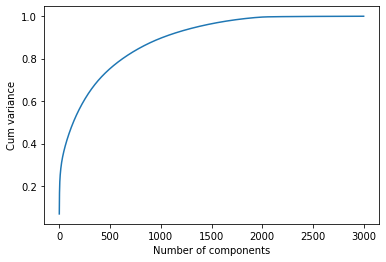

In [ ]:
from sklearn.decomposition import PCA
# First verfiy the ideal number of PCA components to not lose much information. 
# Try to retain 90% information, so look where the curve starts to flatten.
# Remember that the n_components must be lower than the number of rows or columns (features)
pca_test = PCA(n_components=3000) 
#pca_test.fit(trainX)
pca_test.fit(data)
plt.plot(np.cumsum(pca_test.explained_variance_ratio_))
plt.xlabel("Number of components")
plt.ylabel("Cum variance")

In [111]:
#Pick the optimal number of components. This is how many features we will have 
#for our machine learning

n_PCA_components = 1008
pca = PCA(n_components=n_PCA_components)
train_PCA = pca.fit_transform(data)
#test_PCA = pca.transform(data) #Make sure you are just transforming, not fitting.

#If we want 90% information captured we can also try ...
#pca=PCA(0.9)
#train_PCA = pca.fit_transform(data)
#n_PCA_components = len(train_PCA)
#print(principalComponents.shape)
#test_PCA = pca.transform(data)

In [112]:
import pickle as pk
pk.dump(pca, open("data.pkl","wb"))

In [ ]:
'''n_PCA_components = 1008
pca = IncrementalPCA(n_components=n_PCA_components,batch_size=1008)
train_PCA = pca.fit_transform(data)
test_PCA = pca.transform(data)'''

In [36]:
model = Sequential()
model.add(InputLayer(input_shape=(n_PCA_components,)))
model.add(Dense(1008,activation='sigmoid'))
model.add(Dense(1008,activation='relu'))
model.add(Dense(1008,activation='relu'))
#model.add(Dense(1008,activation='sigmoid'))
model.add(Dense(1096, kernel_regularizer=tf.keras.regularizers.l2(0.01),activation='softmax'))

In [16]:
model.load_weights('./HOG_NN/vrindhavan_model_weights_iteration1.h5')

In [ ]:
model.pop()
model.add(Dense(1096, kernel_regularizer=tf.keras.regularizers.l2(0.01),activation='softmax'))
model.summary()

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1008)              1017072   
_________________________________________________________________
dense_1 (Dense)              (None, 1008)              1017072   
_________________________________________________________________
dense_2 (Dense)              (None, 1008)              1017072   
_________________________________________________________________
dense_3 (Dense)              (None, 1008)              1017072   
_________________________________________________________________
dense_4 (Dense)              (None, 1096)              1105864   
Total params: 5,174,152
Trainable params: 5,174,152
Non-trainable params: 0
_________________________________________________________________


In [46]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
model.load_weights('./HOG_NN/vrindhavan_model_weights_iteration1.h5')

checkpoint = ModelCheckpoint("./HOG_NN/vrindhavan_model_weights_iteration1.h5", 
                             monitor='categorical_accuracy', 
                             verbose=1, 
                             save_best_only=True, 
                             save_weights_only=True, 
                             mode='auto', 
                             #save_freq=1
                             )

early = EarlyStopping(monitor='categorical_accuracy', 
                      min_delta=0, 
                      patience=10, 
                      verbose=1, 
                      mode='auto')
Adam(
    learning_rate=0.001,
    beta_1=0.32,
    beta_2=0.397,
    epsilon=9e-08,
    amsgrad=True,
    name="Adam", 
)

model.compile(
    optimizer='Adam',
    loss='categorical_crossentropy',
    metrics=['categorical_accuracy'])

import datetime
start = datetime.datetime.now()
#Fit the model. Do not forget to use on-hot-encoded Y values. 
model.fit(train_PCA,OHE_labels, 
          epochs=108, 
          verbose=1,
          callbacks=[checkpoint,early]
          )

end = datetime.datetime.now()
print("Total execution time with PCA is: ", end-start)

Train on 16439 samples
Epoch 1/108
16352/16439 [============================>.] - ETA: 0s - loss: 0.5878 - categorical_accuracy: 0.9329
Epoch 00001: categorical_accuracy improved from -inf to 0.93272, saving model to ./HOG_NN/vrindhavan_model_weights_iteration1.h5
16439/16439 [==============================] - 12s 730us/sample - loss: 0.5881 - categorical_accuracy: 0.9327
Epoch 2/108
16384/16439 [============================>.] - ETA: 0s - loss: 0.2514 - categorical_accuracy: 0.9720
Epoch 00002: categorical_accuracy improved from 0.93272 to 0.97196, saving model to ./HOG_NN/vrindhavan_model_weights_iteration1.h5
16439/16439 [==============================] - 12s 701us/sample - loss: 0.2514 - categorical_accuracy: 0.9720
Epoch 3/108
16416/16439 [============================>.] - ETA: 0s - loss: 0.2299 - categorical_accuracy: 0.9791
Epoch 00003: categorical_accuracy improved from 0.97196 to 0.97907, saving model to ./HOG_NN/vrindhavan_model_weights_iteration1.h5
16439/16439 [============

In [47]:
test_PCA = pca.transform(data) #Make sure you are just transforming, not fitting.
##Predict on test dataset
predict_test = model.predict(test_PCA)
predict_test = np.argmax(predict_test, axis=1)
predict_test = le.inverse_transform(predict_test)

In [48]:
##Print overall accuracy
from sklearn import metrics
print ("Accuracy = ", metrics.accuracy_score(labels, predict_test))

Accuracy =  0.987043007482207


In [ ]:
#Confusion Matrix - verify accuracy of each class
from sklearn.metrics import confusion_matrix
#testY=str(testY)
cm = confusion_matrix(labels, predict_test)
#print(cm)
sns.heatmap(cm, annot=True)

____0.bead black____
____1.bead_flat____
____2.bead colored____
____3.flat____
____4.flat_color____
____5.Valley____
____6.valley colored____
____7.bead valley____

In [99]:
#Check results on a few select images
n=np.random.randint(0,data.shape[0])
print(n)
val = data[n]
print(val.shape)
x = np.expand_dims(val, axis=0) #Expand dims so the input is (num images, x, y, c)
print(x.shape)
# #Expand dims so the input is (num images, x, y, c)
input_img_feature=x
input_img_PCA = pca.transform(input_img_feature)
prediction_img = model.predict(input_img_PCA)
prediction_img = np.argmax(prediction_img, axis=1)
print(prediction_img)
prediction_img = le.inverse_transform(prediction_img)  #Reverse the label encoder to original name
print("The prediction for this image is: ", prediction_img)
print("The actual label for this image is: ", labels[n])

14390
(7056,)
(1, 7056)
[959]
The prediction for this image is:  ['6467']
The actual label for this image is:  6467


In [91]:
model.save('Vrindhavan_Overall_sukirti.h5')

In [ ]:
SIZE=256
imagepath='./path/Dataset/Vrindhaavan_overall_backup/Vrindavan_overall/1464/Chatshikhar_Cow_Female_13.png'
H=HOG(imagepath,SIZE)
x = np.expand_dims(H, axis=0)
input_img_feature=x
input_img_PCA = pca.transform(input_img_feature)
prediction_img = model.predict(input_img_PCA)
prediction_img = np.argmax(prediction_img, axis=1)
print(prediction_img)
prediction_img = le.inverse_transform(prediction_img)  #Reverse the label encoder to original name
print("The prediction for this image is: ", prediction_img)
#print("The actual label for this image is: ", test_labels[n])

In [ ]:
from tensorflow.keras import Model
SIZE=256
imagepath='./path/Dataset/Vrindhaavan_overall_backup/Vrindavan_overall/1464/Chatshikhar_Cow_Female_13.png'
H=HOG(imagepath,SIZE)
x = np.expand_dims(H, axis=0)
input_img_feature=x
input_img_PCA = pca.fit_transform(input_img_feature)
all_model=load_('./Vrindhavan_Overall_sukirti.h5')
prediction_img = all_model.predict(input_img_PCA)
prediction_img = np.argmax(prediction_img, axis=1)
print(prediction_img)
prediction_img = le.inverse_transform(prediction_img)  #Reverse the label encoder to original name
print("The prediction for this image is: ", prediction_img)
#print("The actual label for this image is: ", test_labels[n])